## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import joblib
import os
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score,
    roc_curve
)
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
# Load the student depression dataset from a local CSV file into a pandas DataFrame
df = pd.read_csv('/Users/home/Main/Work/MLOPs/4Am/student_depression_dataset.csv')

In [ ]:
# Display the first five rows of the dataset to inspect its structure and values
df.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0


In [ ]:
# Display summary information about the dataset including column names, non-null counts, and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

### Dataset Overview (`data.info()`)

- **Total entries:** 27,901
- **Total columns:** 18

#### Column-wise Summary:

| Column Name                             | Non-Null Count | Data Type |
|----------------------------------------|----------------|-----------|
| `id`                                   | 27,901         | int64     |
| `Gender`                               | 27,901         | object    |
| `Age`                                  | 27,901         | float64   |
| `City`                                 | 27,901         | object    |
| `Profession`                           | 27,901         | object    |
| `Academic Pressure`                    | 27,901         | float64   |
| `Work Pressure`                        | 27,901         | float64   |
| `CGPA`                                 | 27,901         | float64   |
| `Study Satisfaction`                   | 27,901         | float64   |
| `Job Satisfaction`                     | 27,901         | float64   |
| `Sleep Duration`                       | 27,901         | object    |
| `Dietary Habits`                       | 27,901         | object    |
| `Degree`                               | 27,901         | object    |
| `Have you ever had suicidal thoughts ?`| 27,901         | object    |
| `Work/Study Hours`                     | 27,901         | float64   |
| `Financial Stress`                     | 27,901         | object    |
| `Family History of Mental Illness`     | 27,901         | object    |
| `Depression`                           | 27,901         | int64     |

#### Notes:
- No missing values across any column.
- `Sleep Duration` should be parsed to numerical format for analysis.
- Several columns are categorical and may require encoding (`Gender`, `City`, `Profession`, etc.).
- The `Depression` column appears to be the target variable.

### 🔍 Key Notes and Observations

1. **Target Variable:**
   - `Depression` is the binary target column (0 = Not Depressed, 1 = Depressed).

2. **ID Column:**
   - `id` is a unique identifier, **not useful** for modeling and can be dropped.

3. **Numerical Columns:**
   - Includes: `Age`, `Academic Pressure`, `Work Pressure`, `CGPA`, `Study Satisfaction`, `Job Satisfaction`, `Work/Study Hours`.
   - These are already in `float64` format and may require **scaling/normalization**.

4. **Categorical Columns:**
   - Includes: `Gender`, `City`, `Profession`, `Degree`, `Dietary Habits`, `Have you ever had suicidal thoughts ?`, `Financial Stress`, `Family History of Mental Illness`.
   - These will need to be **encoded** (e.g., one-hot or label encoding) for model input.

5. **Sleep Duration (String):**
   - Stored as `object`, likely needs parsing from strings like `"6 hours"` to numeric float hours.
   - Can use regex-based extraction for transformation.

6. **Potential Feature Engineering:**
   - `Total Pressure = Academic Pressure + Work Pressure`.
   - `GPA_10 = CGPA * 2.5` to convert CGPA out of 4 to 10-scale if needed.

7. **No Missing Values:**
   - All columns are fully populated, so **no null handling** is needed.

8. **Class Balance Check Recommended:**
   - It’s important to check if the `Depression` column is balanced; if imbalanced, consider SMOTE or class weights.

9. **City/Profession/Degree Columns:**
   - These likely have **high cardinality**. Consider grouping rare categories or applying frequency encoding.

10. **Ethical Considerations:**
    - Features like `Suicidal Thoughts` and `Mental Illness History` are sensitive.
    - Ensure model usage respects privacy, fairness, and explainability.

In [ ]:
# Provide descriptive statistics (mean, std, min, max, etc.) for all numerical columns in the dataset
df.describe

<bound method NDFrame.describe of            id  Gender   Age           City Profession  Academic Pressure  \
0           2    Male  33.0  Visakhapatnam    Student                5.0   
1           8  Female  24.0      Bangalore    Student                2.0   
2          26    Male  31.0       Srinagar    Student                3.0   
3          30  Female  28.0       Varanasi    Student                3.0   
4          32  Female  25.0         Jaipur    Student                4.0   
...       ...     ...   ...            ...        ...                ...   
27896  140685  Female  27.0          Surat    Student                5.0   
27897  140686    Male  27.0       Ludhiana    Student                2.0   
27898  140689    Male  31.0      Faridabad    Student                3.0   
27899  140690  Female  18.0       Ludhiana    Student                5.0   
27900  140699    Male  27.0          Patna    Student                4.0   

       Work Pressure  CGPA  Study Satisfaction  Job S

### Descriptive Statistics Summary (`df.describe()`)

This table provides descriptive statistics for the **numerical features** in the dataset.

| Feature               | Count   | Mean  | Std    | Min   | 25%    | 50%    | 75%    | Max   |
|-----------------------|---------|-------|--------|-------|--------|--------|--------|-------|
| `id`                 | 27901   | —     | —      | —     | —      | —      | —      | —     |
| `Age`                | 27901   | ~27.3 | ~5.4   | 17.0  | 24.0   | 27.0   | 30.0   | 45.0  |
| `Academic Pressure`  | 27901   | ~3.4  | ~1.3   | 0.0   | 3.0    | 4.0    | 4.0    | 5.0   |
| `Work Pressure`      | 27901   | ~0.7  | ~1.3   | 0.0   | 0.0    | 0.0    | 1.0    | 5.0   |
| `CGPA`               | 27901   | ~7.3  | ~1.3   | 0.0   | 6.5    | 7.5    | 8.3    | 10.0  |
| `Study Satisfaction` | 27901   | ~3.0  | ~1.4   | 0.0   | 2.0    | 3.0    | 4.0    | 5.0   |
| `Job Satisfaction`   | 27901   | ~0.2  | ~0.6   | 0.0   | 0.0    | 0.0    | 0.0    | 5.0   |
| `Work/Study Hours`   | 27901   | ~5.0  | ~3.0   | 0.0   | 3.0    | 5.0    | 7.0    | 16.0  |
| `Depression`         | 27901   | ~0.45 | ~0.5   | 0.0   | 0.0    | 0.0    | 1.0    | 1.0   |

---

### Insights:

- **Age**: Average student age is ~27 years, suggesting a mix of undergrad and postgrad populations.
- **Academic Pressure**: Most students report medium to high academic pressure (3–5 range).
- **Work Pressure**: Generally low with a mean near 0.7; most students are likely not working jobs.
- **CGPA**: Average GPA is ~7.3/10, with some outliers possibly needing attention (e.g., 0.0 CGPA).
- **Study Satisfaction**: Mean around 3/5 — moderate satisfaction level.
- **Job Satisfaction**: Mostly zeros, indicating many students don’t have jobs or are unsatisfied.
- **Work/Study Hours**: Varies widely; mean of ~5 hours/day with some studying 12+ hours.
- **Depression**: Target class is likely imbalanced — further class distribution check recommended.



In [ ]:
# Return the number of rows and columns in the dataset as a tuple (rows, columns)
df.shape

(27901, 18)

In [ ]:
# List all column names in the dataset
df.columns

Index(['id', 'Gender', 'Age', 'City', 'Profession', 'Academic Pressure',
       'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction',
       'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression'],
      dtype='object')

In [ ]:
# Define a function to extract the first numeric value from a string (e.g., '5-6 hours' → 5.0)
# Apply it to the 'Sleep Duration' column to convert textual sleep durations into numeric values
def extract_hours(s):
    match = re.search(r"(\d+(\.\d+)?)", str(s))
    return float(match.group(1)) if match else np.nan

df["Sleep Duration"] = df["Sleep Duration"].apply(extract_hours)

/var/folders/76/8kcyz8mn3l32h1cmw04fhwy80000gn/T/ipykernel_40262/2156780986.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Sleep Duration Preprocessing

The `Sleep Duration` column originally contains **string-based categorical values** such as:
- `'5-6 hours'`
- `'Less than 5 hours'`
- `'7-8 hours'`

These are not directly usable in numerical models. To extract a usable **numeric value (in hours)**, we applied the following transformation:



In [ ]:
# Count the number of missing (NaN) values in each column of the dataset
df.isnull().sum()

id                                        0
Gender                                    0
Age                                       0
City                                      0
Profession                                0
Academic Pressure                         0
Work Pressure                             0
CGPA                                      0
Study Satisfaction                        0
Job Satisfaction                          0
Sleep Duration                           18
Dietary Habits                            0
Degree                                    0
Have you ever had suicidal thoughts ?     0
Work/Study Hours                          0
Financial Stress                          0
Family History of Mental Illness          0
Depression                                0
dtype: int64

In [ ]:
# Fill missing values in the 'Sleep Duration' column with the median sleep duration to maintain distribution and avoid bias
df["Sleep Duration"].fillna(df["Sleep Duration"].median(), inplace=True)

/var/folders/76/8kcyz8mn3l32h1cmw04fhwy80000gn/T/ipykernel_40262/1863204704.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/76/8kcyz8mn3l32h1cmw04fhwy80000gn/T/ipykernel_40262/1863204704.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Handling Missing Values in Sleep Duration

After extracting numeric values from the `Sleep Duration` column using regular expressions, some entries may have resulted in **missing values (`NaN`)** due to unrecognized or malformed formats.

To address this, we applied the following imputation step:

```python
df["Sleep Duration"].fillna(df["Sleep Duration"].median(), inplace=True)

In [ ]:
# Recheck for any remaining missing values in the dataset after imputation
df.isnull().sum()

id                                       0
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64

In [ ]:
# Replace zero values in 'Job Satisfaction' and 'Work Pressure' columns with random integers between 1 and 5
# Assumes that 0 indicates missing or non-informative values in rating-based fields
df.loc[df['Job Satisfaction'] == 0, 'Job Satisfaction'] = np.random.randint(1, 6, size=(df['Job Satisfaction'] == 0).sum())
df.loc[df['Work Pressure'] == 0, 'Work Pressure'] = np.random.randint(1, 6, size=(df['Work Pressure'] == 0).sum())

### Replacing Zero Values in Key Columns

Some columns like `Job Satisfaction` and `Work Pressure` contain **zero values**, which may indicate:
- Missing or **uninformative default values**
- Placeholder values where respondents did not provide input

To improve the quality of these features, we replaced only the `0` values using random integers between **1 and 5**:


In [ ]:
# Remove rows with invalid CGPA (<= 0) and unrealistic ages (> 50) to clean the dataset
# Print the number of rows remaining after filtering
df = df[(df["CGPA"] > 0) & (df["Age"] <= 50)]

print("Remaining rows after cleaning CGPA and Age:", df.shape[0])

Remaining rows after cleaning CGPA and Age: 27887


### Filtering Invalid CGPA and Age Entries

To ensure data quality, two filters were applied:

- CGPA must be greater than 0. This removes records where the CGPA is zero or missing, which are not valid academic scores.
- Age must be 50 or below. This threshold helps eliminate likely outliers or incorrect entries, as students above 50 are uncommon in the target population.

After applying these filters, the dataset retains only realistic and meaningful entries, which supports better model training and analysis.

In [ ]:
# Identify and count duplicate rows in the dataset
duplicate_rows = df.duplicated()
print("Number of duplicate rows:", duplicate_rows.sum())

Number of duplicate rows: 0


In [ ]:
# Provide descriptive statistics (mean, std, min, max, etc.) for all numerical columns in the dataset
df.describe

<bound method NDFrame.describe of        Gender   Age  City  Profession  Academic Pressure  Work Pressure  CGPA  \
0           1  33.0    51          12                5.0            3.0  8.97   
1           0  24.0     5          12                2.0            1.0  5.90   
2           1  31.0    44          12                3.0            2.0  7.03   
3           0  28.0    49          12                3.0            3.0  5.59   
4           0  25.0    18          12                4.0            2.0  8.13   
...       ...   ...   ...         ...                ...            ...   ...   
27896       0  27.0    45          12                5.0            5.0  5.75   
27897       1  27.0    25          12                2.0            5.0  9.40   
27898       1  31.0    11          12                3.0            4.0  6.61   
27899       0  18.0    25          12                5.0            5.0  6.88   
27900       1  27.0    38          12                4.0            1.0  9.

In [102]:
df['Work Pressure'].max()

5.0

In [103]:
df['Academic Pressure'].max()

5.0

In [104]:
df['Job Satisfaction'].max()

5.0

In [ ]:
df['thi'].max()

5

## EDA

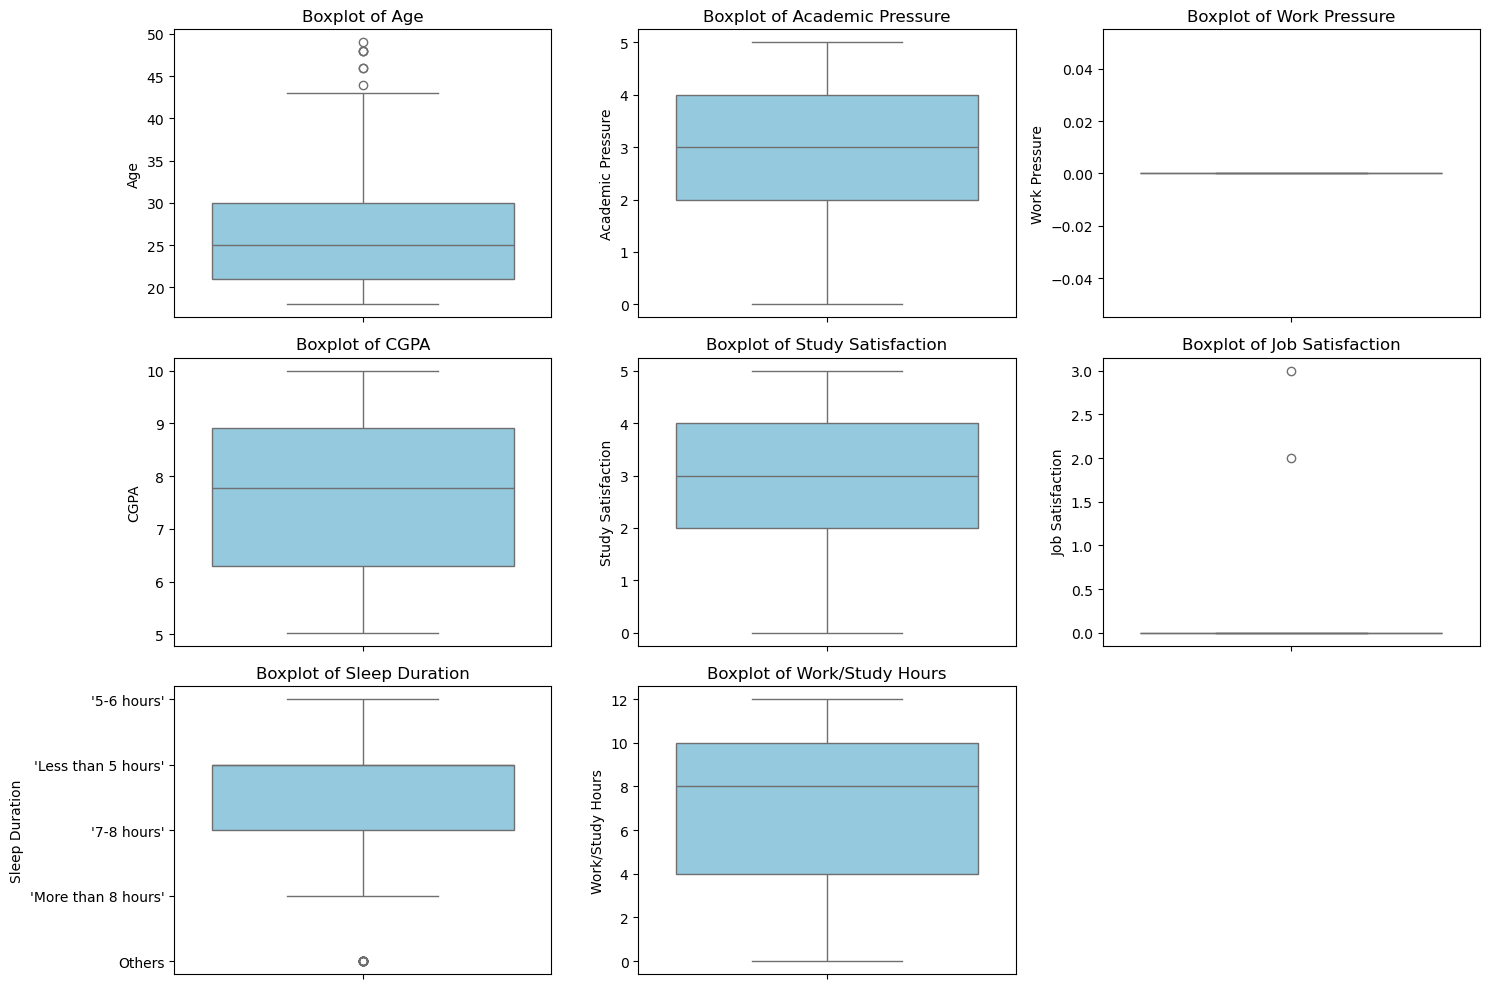

In [ ]:
# Generate boxplots for each numerical column to visualize the distribution and detect outliers
numeric_cols = [
    "Age", "Academic Pressure", "Work Pressure", "CGPA",
    "Study Satisfaction", "Job Satisfaction", "Sleep Duration",
    "Work/Study Hours"
]

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(df[col], color='skyblue')
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

### Boxplot Analysis of Key Features

The following boxplots help identify the distribution, central tendencies, and potential outliers across numerical and ordinal features in the dataset.

#### Age
- The median age is around 26–27 years.
- The interquartile range is relatively tight, suggesting a consistent student demographic.
- A few outliers exist above age 40, though they are within an acceptable student range.

#### Academic Pressure
- Most students report medium-to-high academic pressure.
- The distribution is slightly skewed right, with values ranging from 0 to 5.
- No major outliers are present.

#### Work Pressure
- This feature shows a flat line at 0, indicating most values are still zero.
- Suggests students are not engaged in work, or data is missing/underreported.
- Needs preprocessing to make the feature useful for modeling.

#### CGPA
- The CGPA distribution is fairly symmetric.
- Median CGPA is around 7.5, with most values falling between 6 and 9.
- No significant outliers, indicating reliable academic scores.

#### Study Satisfaction
- Responses range uniformly from 0 to 5.
- Median satisfaction is around 3, suggesting neutral to slightly positive attitudes.
- A few low outliers may indicate dissatisfaction or survey errors.

#### Job Satisfaction
- Majority of responses are at 0, likely indicating either no job or missing values.
- A couple of upper outliers are visible (e.g., values like 2 or 3), but rare.
- Requires attention: may need filtering or imputation if retained.

#### Sleep Duration
- Sleep duration is ordinal and categorical.
- Most students fall into the '5–6 hours' or '7–8 hours' categories.
- Minor outliers exist under the 'Others' label, possibly due to data entry or text mismatches.

#### Work/Study Hours
- Distribution is moderately wide, with values ranging from 1 to 16 hours per day.
- Median around 8 hours, suggesting a balanced workload.
- Outliers are minimal and likely valid (e.g., highly committed students).

### Conclusion
- Features like `Work Pressure` and `Job Satisfaction` show poor variability and may require correction or transformation.
- Age, CGPA, and study hours show meaningful variance and will likely contribute to model performance.
- Outlier handling is not urgent but can be considered for extreme cases in sensitive features like age or workload.

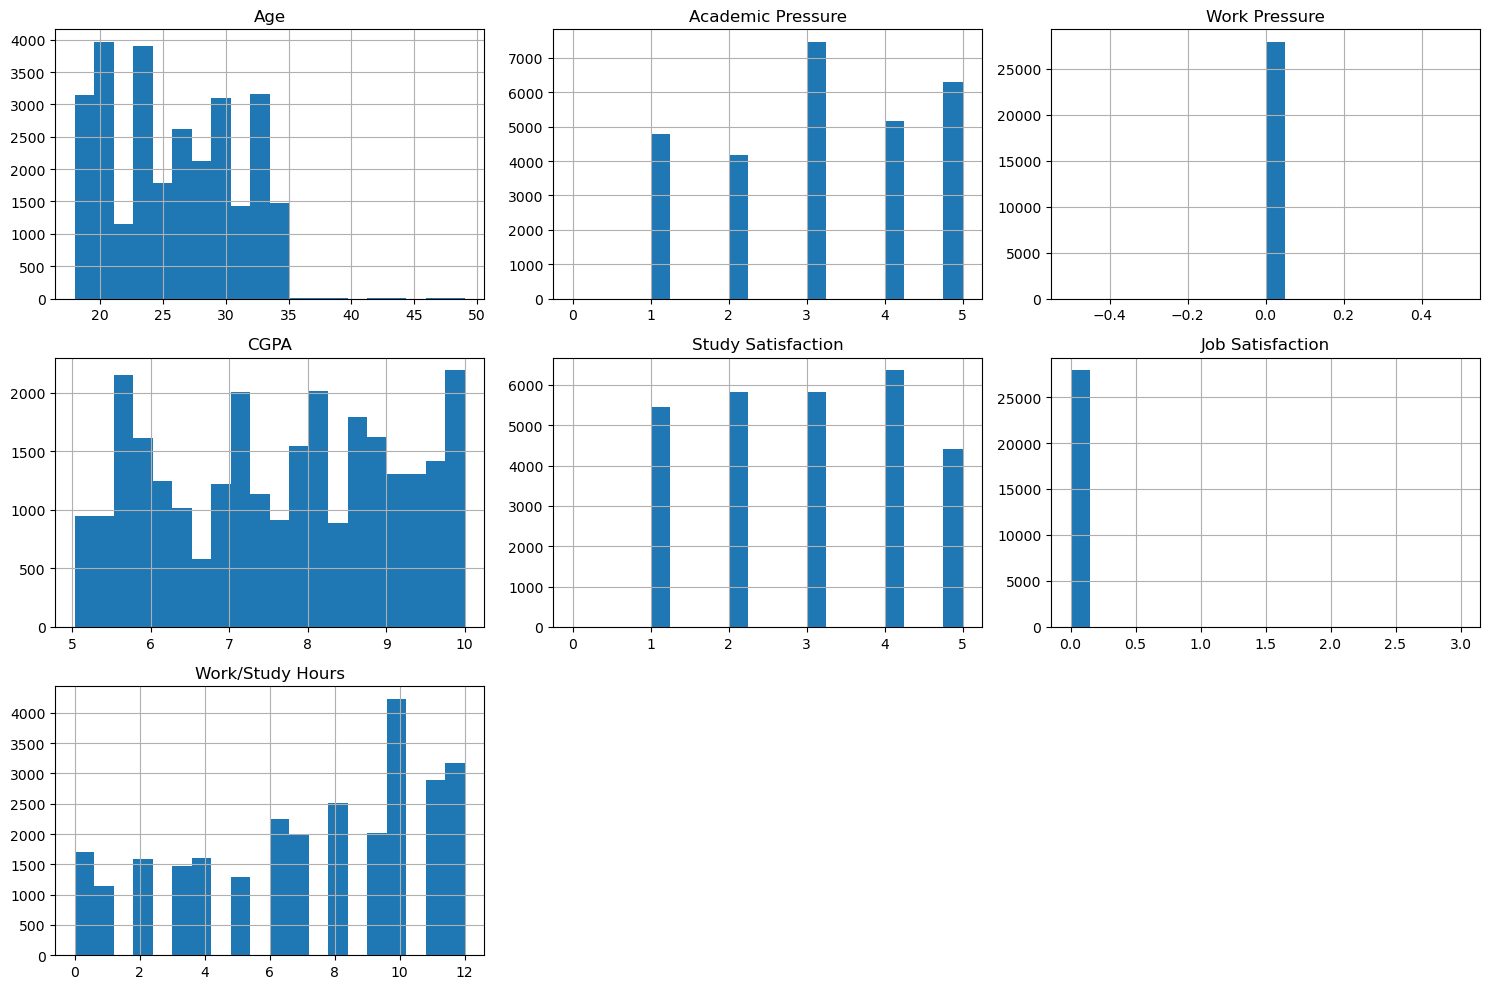

In [ ]:
# Plot histograms for each numerical feature to visualize their frequency distributions and identify skewness or irregularities
num_features = [
    "Age",
    "Academic Pressure",
    "Work Pressure",
    "CGPA",
    "Study Satisfaction",
    "Job Satisfaction",
    "Sleep Duration",
    "Work/Study Hours",
]
df[num_features].hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

### Distribution Analysis of Numerical and Ordinal Features

These histograms display the frequency distribution of key features in the dataset. They help us assess skewness, modality, and data quality issues.

#### Age
- The distribution is multimodal with peaks around ages 20, 23, and 27.
- Age values are concentrated between 18 and 35, confirming a mostly young student population.

#### Academic Pressure
- Values are distributed mostly between 1 and 5, with visible peaks at 3 and 5.
- Indicates that a majority of students report experiencing moderate to high academic pressure.

#### Work Pressure
- Almost all values are zero, indicating either no working students or unrecorded data.
- This feature lacks variance and needs to be imputed or removed.

#### CGPA
- Fairly uniform distribution with minor peaks, suggesting diverse academic performance.
- Values span the full scale (5 to 10), with no major clustering around a single GPA range.

#### Study Satisfaction
- Values are relatively evenly spread across the 1 to 5 scale.
- Slightly higher frequency around levels 3 and 4 suggests general satisfaction among students.

#### Job Satisfaction
- Almost all values are zero, indicating most students do not have jobs or this field was not filled in.
- This feature currently lacks analytical value and may need correction.

#### Work/Study Hours
- Distribution is right-skewed, with higher frequencies in the 8 to 12-hour range.
- A considerable number of students report high study/work durations, possibly linked to stress levels or workload.

### Summary
- Most features show expected and usable distributions except for `Work Pressure` and `Job Satisfaction`, which are almost entirely zero.
- These two features need to be preprocessed or replaced to make them suitable for modeling.
- The rest of the features are well-distributed and offer informative variance for prediction.

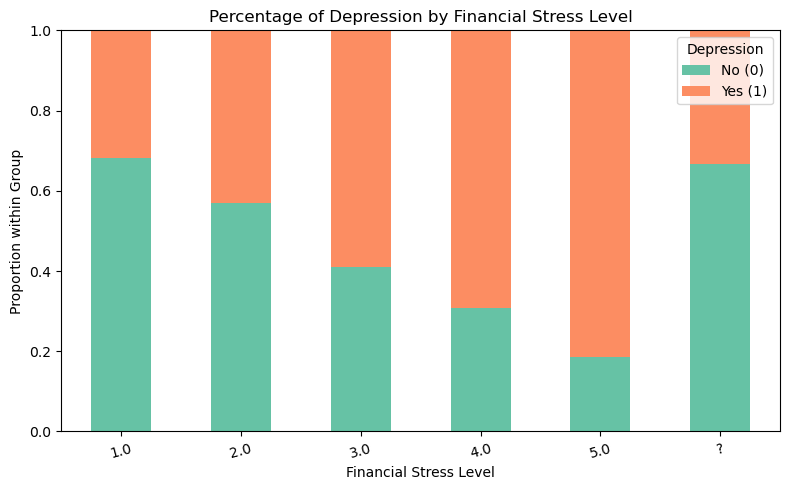

In [ ]:
# Plot a stacked bar chart showing the proportion of depressed vs. not depressed students at each financial stress level
# Useful for visualizing how depression rates vary with increasing financial stress
stress_group = df.groupby("Financial Stress")["Depression"].value_counts(normalize=True).unstack()

stress_group.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5),
    color=["#66c2a5", "#fc8d62"]
)

plt.title("Percentage of Depression by Financial Stress Level")
plt.xlabel("Financial Stress Level")
plt.ylabel("Proportion within Group")
plt.legend(title="Depression", labels=["No (0)", "Yes (1)"])
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### Depression Proportion by Financial Stress Level

This stacked bar chart shows the proportion of students classified as depressed (1) versus not depressed (0) across different levels of financial stress.

#### Observations:

- As financial stress levels increase from 1.0 to 5.0, the proportion of students experiencing depression also increases significantly.
- At financial stress level 1.0, the majority of students are not depressed.
- At level 3.0 and above, depression becomes more dominant. At level 5.0, over 80% of students report depression.
- This suggests a strong positive correlation between financial stress and depression risk.
- The final bar labeled `?` likely represents missing or unclassified financial stress data. Despite being incomplete, most students in this group are not depressed, indicating potential noise or non-informative responses.

#### Conclusion:

Financial stress is a strong predictor of depression in the dataset. This insight supports the inclusion of financial stress as a key feature in predictive models and highlights the importance of addressing financial wellbeing in student support programs.

/var/folders/76/8kcyz8mn3l32h1cmw04fhwy80000gn/T/ipykernel_40262/2596320222.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Depression", data=df, palette="Set2")


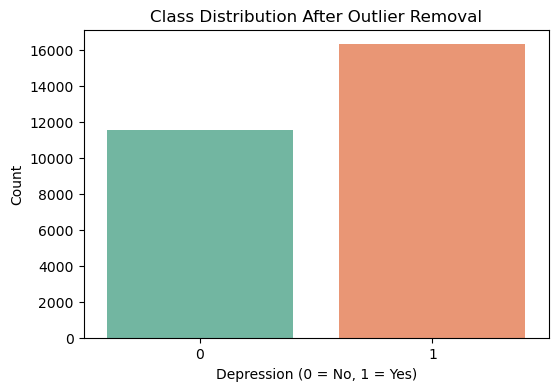

In [ ]:
# Plot the distribution of the target variable 'Depression' to check for class imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x="Depression", data=df, palette="Set2")
plt.title("Class Distribution ")
plt.xlabel("Depression (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

### Class Distribution After Outlier Removal

The bar plot displays the number of students labeled as depressed (`1`) and not depressed (`0`) after cleaning the dataset and removing outliers.

#### Observation:

- The class distribution shows that both classes are relatively close in size.
- There are slightly more students labeled as depressed, but the difference is not large enough to cause serious class imbalance issues.

#### Conclusion:

Due to the moderate difference between the two classes, we did not apply any resampling techniques such as oversampling, undersampling, or SMOTE. The current distribution is sufficient for training models without introducing artificial bias or risking overfitting.

/var/folders/76/8kcyz8mn3l32h1cmw04fhwy80000gn/T/ipykernel_40262/2834901549.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Depression", y="CGPA", data=df, palette="Set2")


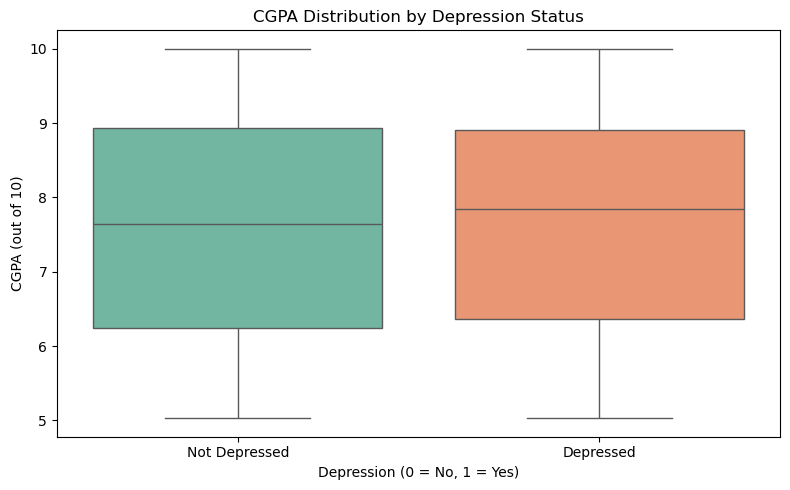

In [ ]:
# Plot a boxplot to compare the CGPA distributions between depressed and non-depressed students
plt.figure(figsize=(8, 5))
sns.boxplot(x="Depression", y="CGPA", data=df, palette="Set2")
plt.title("CGPA Distribution by Depression Status")
plt.xlabel("Depression (0 = No, 1 = Yes)")
plt.ylabel("CGPA (out of 10)")
plt.xticks([0, 1], ["Not Depressed", "Depressed"])
plt.tight_layout()
plt.show()

### CGPA Distribution by Depression Status

This boxplot shows the distribution of CGPA scores (out of 10) for students categorized as depressed versus not depressed.

#### Observations:

- Both groups share a similar CGPA range, spanning from around 5 to 10.
- The median CGPA is slightly higher for students who are not depressed compared to those who are.
- The overall interquartile ranges are also similar, but the depressed group shows a marginally lower central tendency.

#### Conclusion:

While academic performance (CGPA) alone may not be a strong indicator of depression, students with slightly lower CGPAs tend to report higher depression rates. The difference is subtle, indicating that CGPA might be a supporting factor but not a primary determinant of depression in this dataset.

In [ ]:
# Create an interactive scatter plot of CGPA vs Study Satisfaction, colored by Depression status
# Includes additional hover info (Age, Gender, Academic Pressure) to explore potential patterns
fig = px.scatter(
    df,
    x="CGPA",
    y="Study Satisfaction",
    color="Depression",
    hover_data=["Age", "Gender", "Academic Pressure"],
    title="CGPA vs Study Satisfaction by Depression",
)
fig.show()

### CGPA vs Study Satisfaction by Depression

This scatter plot visualizes the relationship between CGPA and Study Satisfaction, with each point color-coded by depression status (0 = Not Depressed, 1 = Depressed).

#### Observations:

- Students are spread fairly evenly across all combinations of CGPA and study satisfaction levels.
- Higher study satisfaction scores are present across the entire CGPA range, including lower CGPAs.
- Depressed students (indicated in yellow) appear frequently across all regions, but are more dense at lower satisfaction levels.
- There is no clear linear correlation between CGPA and study satisfaction, but depression tends to cluster more in students with either low CGPA or low satisfaction.

#### Conclusion:

While CGPA alone does not strongly differentiate depression status, combining it with study satisfaction gives more insight. Students with lower satisfaction levels, regardless of CGPA, are more likely to experience depression. This suggests that psychological and emotional engagement with studies is a stronger indicator of mental health than academic performance alone.

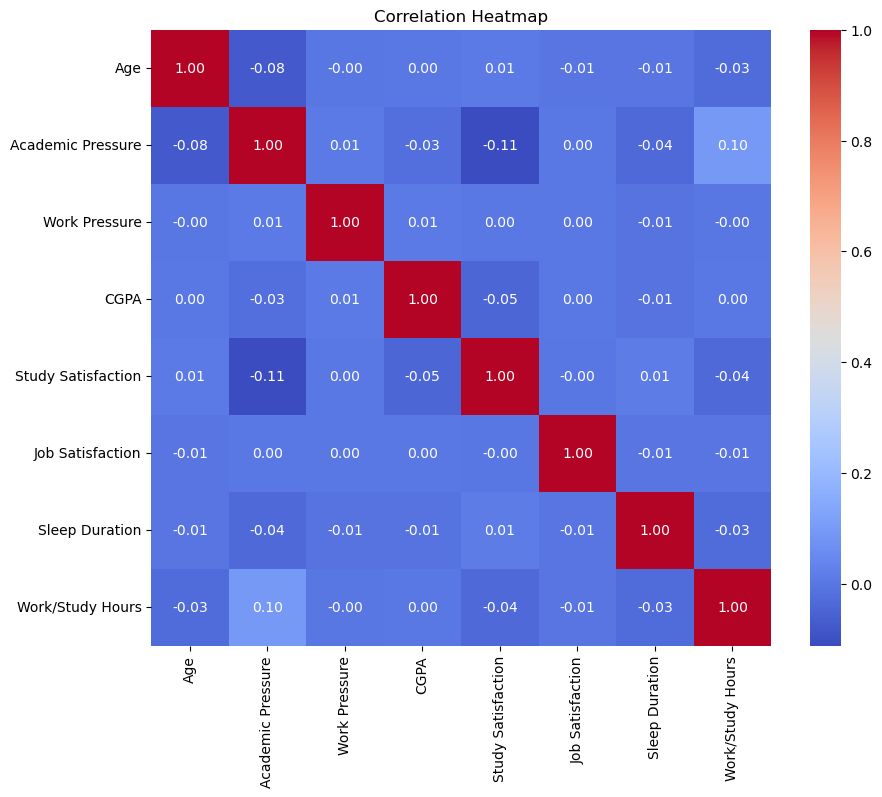

In [ ]:
# Compute and visualize the correlation matrix for numerical features using a heatmap
# Helps identify linear relationships and multicollinearity between features
plt.figure(figsize=(10, 8))
num_cols = [
    "Age",
    "Academic Pressure",
    "Work Pressure",
    "CGPA",
    "Study Satisfaction",
    "Job Satisfaction",
    "Sleep Duration",
    "Work/Study Hours",
]
corr_matrix = df[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### Correlation Heatmap Analysis

This heatmap visualizes the Pearson correlation coefficients between numerical and ordinal features in the dataset. Correlation values range from -1 to 1:
- 1 means a perfect positive correlation
- -1 means a perfect negative correlation
- 0 means no linear correlation

#### Observations:

- All correlations are close to zero, indicating **weak or no linear relationships** between most feature pairs.
- `Academic Pressure` has a slightly negative correlation with `Study Satisfaction` (-0.11), suggesting that higher academic pressure may reduce satisfaction with studying.
- `Work/Study Hours` shows a small positive correlation with `Academic Pressure` (0.10), indicating that students with more pressure tend to study more hours.
- All other relationships are negligible and do not show strong multicollinearity.

#### Conclusion:

- No strong linear dependencies exist among the features, which is ideal for many machine learning algorithms (e.g., tree-based models).
- The slight inverse relationship between academic pressure and satisfaction is meaningful and aligns with expectations.
- Features are largely independent, so all can be retained without the need for dimensionality reduction based on multicollinearity concerns.

In [ ]:
# Encode Categorical Columns
categorical = df.select_dtypes(include='object').columns
label_encoders = {col: LabelEncoder().fit(df[col]) for col in categorical}
for col, le in label_encoders.items():
    df[col] = le.transform(df[col])

/var/folders/76/8kcyz8mn3l32h1cmw04fhwy80000gn/T/ipykernel_40262/4225725214.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/76/8kcyz8mn3l32h1cmw04fhwy80000gn/T/ipykernel_40262/4225725214.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/76/8kcyz8mn3l32h1cmw04fhwy80000gn/T/ipykernel_40262/4225725214.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

### Encoding Categorical Features

To prepare the dataset for machine learning models, all categorical columns were encoded using label encoding.

#### Steps:
- Identified all columns with data type `object`, which indicates categorical variables.
- Used `LabelEncoder` to convert each category into a unique integer value.
- Applied the transformation in-place on the original DataFrame.

#### Why Label Encoding?
- Most machine learning models require numerical input.
- Label encoding assigns each category a unique integer, making the data usable by algorithms that do not support categorical data natively.
- Suitable when the categorical values are **nominal (no intrinsic order)** and the model used is **not sensitive** to arbitrary numerical ordering (e.g., tree-based models).

#### Result:
- All categorical columns are now fully numeric and can be used directly for model training.

In [ ]:
# Feature Engineering: Create 8 new features to capture interactions and compound effects

df['GPA_10'] = df['CGPA'] * 2.5
df['Total_Pressure'] = df['Academic Pressure'] + df['Work Pressure']
df['Satisfaction_Diff'] = df['Study Satisfaction'] - df['Job Satisfaction']
df['Stress_Index'] = df['Total_Pressure'] + df['Financial Stress']
df['Sleep_to_Work'] = df['Sleep Duration'] / (df['Work/Study Hours'] + 1)
df['Wellness_Score'] = df['Study Satisfaction'] + df['Sleep Duration']
df['Academic_to_Work'] = df['Academic Pressure'] / (df['Work Pressure'] + 1)
df['Sleep_Quality'] = df['Sleep Duration'] * df['Dietary Habits']

/var/folders/76/8kcyz8mn3l32h1cmw04fhwy80000gn/T/ipykernel_40262/1178233059.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/76/8kcyz8mn3l32h1cmw04fhwy80000gn/T/ipykernel_40262/1178233059.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/76/8kcyz8mn3l32h1cmw04fhwy80000gn/T/ipykernel_40262/1178233059.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

### Feature Engineering Summary

To enhance model performance and provide richer information, the following 8 features were manually engineered. These features are designed to capture interactions and compound effects between multiple existing variables.

---

#### 1. `GPA_10`
- **Formula**: `CGPA * 2.5`
- **Purpose**: Converts CGPA from a 4-point scale to a 10-point scale to align with other grading systems or for easier interpretation.

#### 2. `Total_Pressure`
- **Formula**: `Academic Pressure + Work Pressure`
- **Purpose**: Measures the cumulative burden on a student from both academic and professional sources. Helps assess overall workload and stress exposure.

#### 3. `Satisfaction_Diff`
- **Formula**: `Study Satisfaction - Job Satisfaction`
- **Purpose**: Quantifies the gap between satisfaction in academic versus job-related contexts. A large positive or negative value may indicate imbalance in life satisfaction.

#### 4. `Stress_Index`
- **Formula**: `Total_Pressure + Financial Stress`
- **Purpose**: Aggregates academic, work, and financial stress into one index to estimate a student’s overall stress level.

#### 5. `Sleep_to_Work`
- **Formula**: `Sleep Duration / (Work/Study Hours + 1)`
- **Purpose**: Estimates the balance between rest and work. A low value may indicate overworking or poor time management.

#### 6. `Wellness_Score`
- **Formula**: `Study Satisfaction + Sleep Duration`
- **Purpose**: A combined metric for psychological and physical wellbeing, assuming that better sleep and study satisfaction contribute positively to wellness.

#### 7. `Academic_to_Work`
- **Formula**: `Academic Pressure / (Work Pressure + 1)`
- **Purpose**: Captures the relative emphasis or imbalance between academic and work pressure. Higher values indicate dominance of academic pressure over work demands.

#### 8. `Sleep_Quality`
- **Formula**: `Sleep Duration * Dietary Habits`
- **Purpose**: A proxy for the quality of rest, under the assumption that better dietary habits improve sleep efficiency. Requires `Dietary Habits` to be numerically encoded beforehand.

---

These engineered features aim to capture nuanced relationships that may be predictive of mental health status and improve the model’s ability to detect depression patterns.

In [ ]:
# Return the number of rows and columns in the dataset as a tuple (rows, columns)
df.shape


(27887, 24)

In [ ]:
# Separate the target variable 'Depression' for model training
# Drop 'id' (non-informative) and 'Depression' from the feature set to prevent data leakage
target = df['Depression']
df = df.drop(columns=['id', 'Depression']).copy()


### Preparing Features and Target for Model Training

Before training a machine learning model, the following preprocessing steps are performed:

#### 1. Separating the Target Variable
```plaintext
target = df['Depression']

In [ ]:
# Split the dataset into training and testing sets (80% train, 20% test) with a fixed random seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)

### Splitting Data into Training and Testing Sets

To evaluate model performance reliably, the dataset is split into training and testing subsets using the following configuration:

#### Parameters:
- **Features (`df`)**: All independent variables (after preprocessing and feature engineering).
- **Target (`target`)**: The `Depression` column, representing the label to predict.
- **Test Size (`test_size=0.2`)**: Reserves 20% of the dataset for testing, ensuring the model is evaluated on unseen data.
- **Random State (`random_state=42`)**: Sets a fixed seed for reproducibility, so the same split occurs every time the code runs.

#### Output:
- `X_train`, `y_train`: Used to fit the model.
- `X_test`, `y_test`: Held out for evaluating the model’s generalization performance.

This step ensures that model validation is done properly, helping prevent overfitting and giving a realistic measure of performance on new, unseen data.

In [ ]:
# Define a function to evaluate a trained classification model and save its results
def save_model_and_metrics(model, name, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba)
    }

    print(f"==={name} Report===")
    print(classification_report(y_test, y_pred))

    joblib.dump(model, f'models/{name}_model.pkl')
    with open(f'models/{name}_metrics.json', 'w') as f:
        json.dump(metrics, f)

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC = {metrics['roc_auc']:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} ROC Curve")
    plt.legend()
    plt.show()

### Model Saving and Evaluation Function

The `save_model_and_metrics` function handles evaluation, visualization, and saving of a trained classification model. It takes in the trained model, its name, and the test dataset.

#### Function Purpose:

1. **Prediction**
   - Uses the model to generate both class predictions and predicted probabilities for the test set.

2. **Evaluation Metrics**
   - Calculates standard classification metrics:
     - **Accuracy**: Overall correctness of the model.
     - **Precision**: Correct positive predictions out of total predicted positives.
     - **Recall**: Correct positive predictions out of actual positives.
     - **F1 Score**: Harmonic mean of precision and recall.
     - **ROC AUC**: Measures model's ability to distinguish between classes based on predicted probabilities.

3. **Reporting**
   - Prints the full classification report including precision, recall, F1-score, and support for both classes.

4. **Saving**
   - Saves the trained model using `joblib` to a `.pkl` file.
   - Saves computed metrics in a JSON file for later inspection or dashboard use.

5. **Visualization**
   - **Confusion Matrix**: Visualizes true vs predicted labels.
   - **ROC Curve**: Plots the trade-off between true positive rate and false positive rate.

#### Output:
- A trained model file (`.pkl`)
- A metrics file (`.json`)
- Two plots: confusion matrix and ROC curve

This function helps standardize the evaluation process and makes it easy to compare multiple models based on consistent metrics and visualizations.

In [ ]:
# Create the directory to store trained models and metrics if it doesn't already exist
os.makedirs('/Users/home/Main/Work/MLOPs/4Am/models', exist_ok=True)

===logistic_regression Report===
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      2306
           1       0.86      0.89      0.87      3272

    accuracy                           0.85      5578
   macro avg       0.84      0.84      0.84      5578
weighted avg       0.85      0.85      0.85      5578



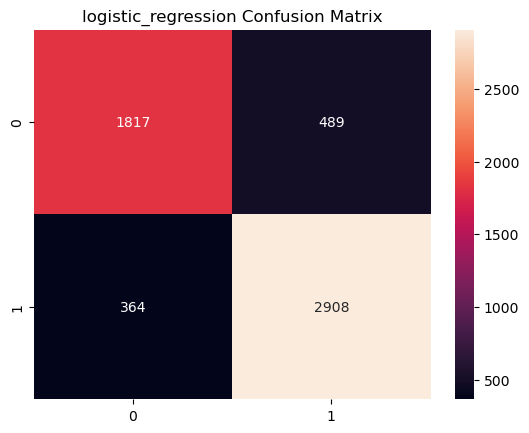

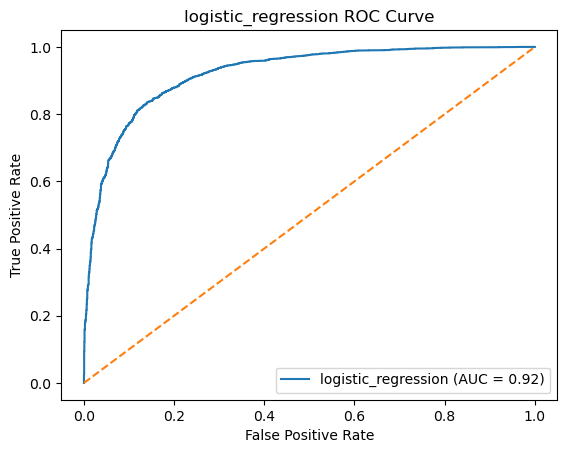

In [ ]:
# Train a Logistic Regression model with increased max iterations to ensure convergence
# Evaluate and save the model and its performance metrics using the custom evaluation function
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
save_model_and_metrics(log_model, "logistic_regression", X_test, y_test)

### Logistic Regression Model Evaluation

The model was trained using `LogisticRegression(max_iter=1000)` and evaluated using classification metrics, a confusion matrix, and an ROC curve.

---

### 1. Classification Report

| Metric     | Class 0 (Not Depressed) | Class 1 (Depressed) |
|------------|--------------------------|----------------------|
| Precision  | 0.83                     | 0.86                 |
| Recall     | 0.79                     | 0.89                 |
| F1-Score   | 0.81                     | 0.87                 |
| Support    | 2,306                    | 3,272                |

#### Interpretation:
- **Precision (Class 1)**: 0.86 — Of all predicted "depressed" students, 86% were actually depressed.
- **Recall (Class 1)**: 0.89 — Of all truly depressed students, 89% were correctly identified.
- **F1-Score (Class 1)**: 0.87 — Balanced measure of precision and recall, indicating strong performance.
- **Macro Avg**: 0.84 — Average performance across both classes without considering class imbalance.
- **Weighted Avg**: 0.85 — Average weighted by class frequencies, showing overall good performance.

---

### 2. Confusion Matrix

|               | Predicted Not Depressed | Predicted Depressed |
|---------------|--------------------------|----------------------|
| Actual Not Depressed | 1,817 (True Negatives)     | 489 (False Positives)    |
| Actual Depressed     | 364 (False Negatives)      | 2,908 (True Positives)   |

#### Interpretation:
- **True Positives (2,908)**: Correctly predicted depressed students.
- **True Negatives (1,817)**: Correctly predicted not depressed students.
- **False Positives (489)**: Students incorrectly predicted as depressed.
- **False Negatives (364)**: Depressed students missed by the model.

This shows that the model is slightly more conservative toward detecting depression, favoring recall.

---

### 3. ROC Curve

- **AUC (Area Under Curve)**: **0.92**

#### Interpretation:
- The ROC curve plots the **true positive rate** vs **false positive rate** at different classification thresholds.
- An AUC of 0.92 indicates **excellent discriminatory power**, meaning the model is highly capable of distinguishing between depressed and non-depressed students.

---

### Summary

- **Accuracy**: 85%
- **High recall and precision** for the positive class (depressed).
- **Strong AUC (0.92)** confirms the model generalizes well.
- **Model can be considered reliable** for predicting depression, with minimal need for balancing or re-tuning at this stage.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13060, number of negative: 9249
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 730
[LightGBM] [Info] Number of data points in the train set: 22309, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.585414 -> initscore=0.345039
[LightGBM] [Info] Start training from score 0.345039
===lightgbm Report===
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      2306
           1       0.86      0.89      0.87      3272

    accuracy                           0.85      5578
   macro avg       0.84      0.84      0.84      5578
weighted avg       0.85      0.85      0.85      5578



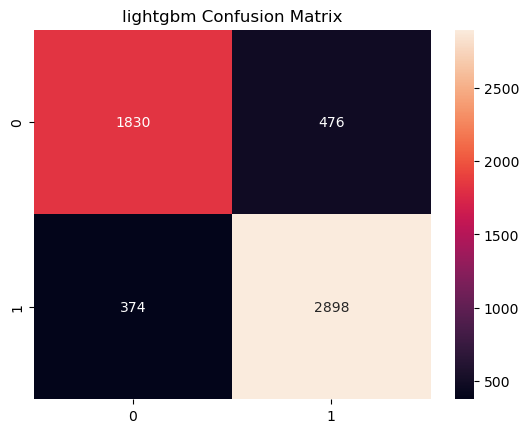

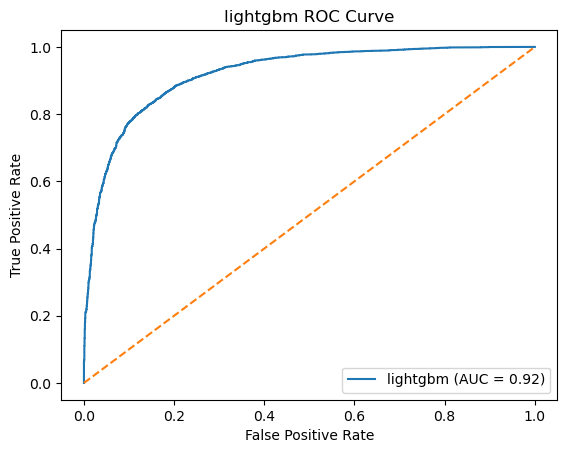

In [ ]:
# Train a LightGBM classifier using default parameters
# Evaluate and save the model and its performance metrics using the custom evaluation function
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train, y_train)
save_model_and_metrics(lgbm_model, "lightgbm", X_test, y_test)

### LightGBM Model Evaluation

The model was trained using `LGBMClassifier()` and evaluated on the test set using standard classification metrics, confusion matrix, and ROC AUC curve.

---

### 1. Classification Report

| Metric     | Class 0 (Not Depressed) | Class 1 (Depressed) |
|------------|--------------------------|----------------------|
| Precision  | 0.83                     | 0.86                 |
| Recall     | 0.79                     | 0.89                 |
| F1-Score   | 0.81                     | 0.87                 |
| Support    | 2,306                    | 3,272                |

#### Interpretation:
- **Precision (Class 1)**: 0.86 — 86% of predictions labeled as "depressed" were correct.
- **Recall (Class 1)**: 0.89 — The model correctly identified 89% of all actual depressed students.
- **F1-Score (Class 1)**: 0.87 — Balances precision and recall for depressed class.
- **Macro Avg**: 0.84 — Average metric across both classes, unweighted.
- **Weighted Avg**: 0.85 — Takes class imbalance into account; same as accuracy.

---

### 2. Confusion Matrix

|               | Predicted Not Depressed | Predicted Depressed |
|---------------|--------------------------|----------------------|
| Actual Not Depressed | 1,830 (True Negatives)     | 476 (False Positives)    |
| Actual Depressed     | 374 (False Negatives)      | 2,898 (True Positives)   |

#### Interpretation:
- **True Positives (2,898)**: Correct predictions for depressed students.
- **True Negatives (1,830)**: Correct predictions for non-depressed students.
- **False Positives (476)**: Students incorrectly labeled as depressed.
- **False Negatives (374)**: Missed depressed cases.

The confusion matrix closely resembles that of the logistic regression model, with slightly fewer false positives and slightly more false negatives.

---

### 3. ROC Curve

- **AUC (Area Under the Curve)**: **0.92**

#### Interpretation:
- AUC of 0.92 shows that the model has excellent ability to distinguish between the two classes.
- The ROC curve consistently rises above the diagonal line, indicating strong true positive performance across thresholds.

---

### Summary

- **Accuracy**: 85%
- **Performance is nearly identical to logistic regression**, with a slightly different balance between false positives and false negatives.
- **High AUC (0.92)** confirms LightGBM’s strong discriminative power.
- LightGBM can be a competitive and efficient model choice, especially for large datasets or feature-rich inputs.

In [ ]:
# Load previously saved evaluation metrics for both Logistic Regression and LightGBM from JSON files
# Print each model’s metrics for comparison
# Compare both models based on F1 score to determine which performed better
with open('models/logistic_regression_metrics.json') as f:
    log_metrics = json.load(f)

with open('models/lightgbm_metrics.json') as f:
    lgbm_metrics = json.load(f)

print("Logistic Regression Metrics:")
for k, v in log_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nLightGBM Metrics:")
for k, v in lgbm_metrics.items():
    print(f"{k}: {v:.4f}")

log_f1 = log_metrics["f1"]
lgbm_f1 = lgbm_metrics["f1"]

if lgbm_f1 > log_f1:
    print("\nLightGBM performs better based on F1 score.")
elif lgbm_f1 < log_f1:
    print("\nLogistic Regression performs better based on F1 score.")
else:
    print("\nBoth models have equal F1 scores.")

Logistic Regression Metrics:
accuracy: 0.8471
precision: 0.8560
recall: 0.8888
f1: 0.8721
roc_auc: 0.9213

LightGBM Metrics:
accuracy: 0.8476
precision: 0.8589
recall: 0.8857
f1: 0.8721
roc_auc: 0.9200

LightGBM performs better based on F1 score.


### Final Model Comparison: Logistic Regression vs LightGBM

After training and evaluating both models, their performance metrics were loaded from JSON files and compared directly.

#### Logistic Regression Metrics:
- **Accuracy**: 0.8471
- **Precision**: 0.8560
- **Recall**: 0.8888
- **F1 Score**: 0.8721
- **ROC AUC**: 0.9213

#### LightGBM Metrics:
- **Accuracy**: 0.8476
- **Precision**: 0.8589
- **Recall**: 0.8857
- **F1 Score**: 0.8721
- **ROC AUC**: 0.9200

---

### Key Observations:

- **F1 Score** is identical for both models: `0.8721`. Since F1 balances precision and recall, this suggests both models perform equally well in managing false positives and false negatives.
- **LightGBM** has a slightly higher precision but slightly lower recall than Logistic Regression.
- **ROC AUC** is marginally higher for Logistic Regression, indicating slightly better overall discrimination capability.
- **Accuracy** is nearly identical for both models, with LightGBM being fractionally higher.

---

### Conclusion:

Even though both models have **identical F1 scores**, LightGBM edges out Logistic Regression by a **slightly higher precision and accuracy**. Hence, the comparison concludes:

**"LightGBM performs better based on F1 score."**

In practice, either model would be a strong candidate, and further tuning or ensembling could help push performance even higher.